# 5.4 应用：可视化有效前沿

<div class="alert alert-block alert-success">
本应用将利用4种股票资产的价格，模拟成千上万种可能的投资组合，并利用组合优化技术，构建基于最大化夏普比率的投资组合，最后绘制有效前沿。通过本应用，将熟悉单个股票对数收益率的计算、投资组合收益率和波动率的计算，构建投资组合和投资组合可视化的整个过程。
</div>


“现代投资组合理论（MPT）”是由哈里·马科维茨在他的论文《投资组合选择》中提出的假设（该论文于1952年由《金融杂志》发表），是一种基于这样一个理念的投资理论：风险厌恶的投资者可以构建投资组合，以优化或最大化基于给定市场风险水平的预期回报。它是处理金融和投资领域最重要和最具影响力的经济理论之一。

本节需要使用pip安装如下库：
```
pip install scipy --user -i https://mirrors.aliyun.com/pypi/simple
```

> SciPy（Scientific Python）是一个开源的Python科学计算库，它构建在NumPy之上，并提供了许多用于科学计算和技术计算的高级功能。SciPy提供了许多用于优化、数值积分、插值、线性代数、统计、信号处理、图像处理、常微分方程求解等方面的功能。



## 1. 载入数据

### 1.1 读取数据文件

读取名为 'stocks.csv' 的CSV文件，并将其加载到一个名为 stocks 的Pandas DataFrame中。该DataFrame被设置为以日期作为索引，并解析日期列为日期时间对象。

In [1]:
import pandas as pd
stocks = pd.read_csv('datasets/stocks.csv', index_col='Date', parse_dates=True)

/Users/xhc/miniconda3/envs/d2l/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


除了这种方法，你也可以先读取读取数据，再处理日期

In [2]:
data = pd.read_csv('datasets/stocks.csv', index_col='Date')
data.index = pd.to_datetime(data.index)                       # 行索引，字符串格式——>日期格式

In [3]:
stocks.head()

aapl      cisco         ibm    amzn
Date                                                
2012-01-03  53.063218  15.752778  160.830881  179.03
2012-01-04  53.348386  16.057180  160.174781  177.51
2012-01-05  53.940658  15.997991  159.415086  177.61
2012-01-06  54.504543  15.938801  157.584912  182.61
2012-01-09  54.418089  16.040268  156.764786  178.56

### 1.2 绘制价格走势曲线

处理股票价格使初始价格为1，然后绘制折线图通常用于比较不同股票的相对表现。

In [4]:
stock_normed = stocks/stocks.iloc[0]

In [5]:
import matplotlib.pyplot as plt
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg') 

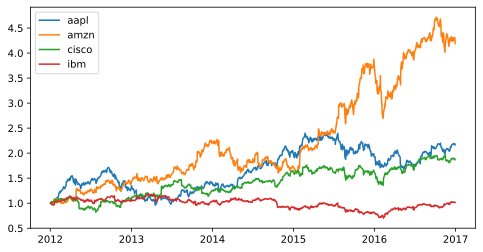

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(stock_normed['aapl'], label='aapl')
plt.plot(stock_normed['amzn'], label='amzn')
plt.plot(stock_normed['cisco'], label='cisco')
plt.plot(stock_normed['ibm'], label='ibm')
plt.legend()

## 2. 收益率的描述性统计

### 2.1 计算对数收益率

我们现在将转而使用对数收益率而不是算术收益率，对于我们的许多用例，它们几乎相同，但大多数技术分析需要对时间序列进行去趋势化/归一化，使用[对数收益率是一个不错的方法](https://quantivity.wordpress.com/2011/02/21/why-log-returns/)。对数收益率在我们将遇到的许多算法中非常方便使用。


对数收益率（logarithmic return）可以使用以下公式计算：

$$ r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) $$

其中：
- $ r_t $ 是在时间 $ t $ 的对数收益率；
- $ P_t $ 是在时间 $ t $ 的资产价格；
- $ P_{t-1} $ 是在时间 $ t-1 $ 的资产价格；
- $ \ln $ 表示自然对数。

对数收益率可以用来表示资产价格的相对变化，因为它可以消除价格水平的影响，并且具有更好的数学性质，例如可加性。这使得对数收益率在金融领域中被广泛应用于风险和收益的计算和分析。

In [7]:
import numpy as np
log_ret = np.log(stocks/stocks.shift(1))
log_ret.head()

aapl     cisco       ibm      amzn
Date                                              
2012-01-03       NaN       NaN       NaN       NaN
2012-01-04  0.005360  0.019139 -0.004088 -0.008526
2012-01-05  0.011041 -0.003693 -0.004754  0.000563
2012-01-06  0.010400 -0.003707 -0.011547  0.027763
2012-01-09 -0.001587  0.006346 -0.005218 -0.022428

### 2.2 收益率的分布

绘制对数收益率的频数分布图

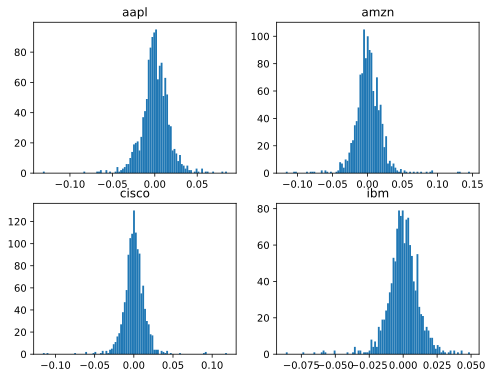

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8,6)) 
ax[0,0].hist(log_ret['aapl'], bins=100)
ax[0,1].hist(log_ret['amzn'], bins=100)
ax[1,0].hist(log_ret['cisco'], bins=100)
ax[1,1].hist(log_ret['ibm'], bins=100)
ax[0,0].set_title('aapl')
ax[0,1].set_title('amzn')
ax[1,0].set_title('cisco')
ax[1,1].set_title('ibm')
plt.show()

尖峰肥尾（Fat-tailedness）现象在金融资产收益率中普遍存在。它指的是其收益率分布中尾部的厚重程度，与正态分布相比，尾部更肥厚。这意味着在实际情况下，较小概率事件发生的可能性更高，表明金融资产可能存在更大的风险，因为价格波动或损失可能比预期更大。

### 2.3 描述性统计

In [9]:
log_ret.describe().transpose()

count      mean       std       min       25%       50%       75%  \
aapl   1257.0  0.000614  0.016466 -0.131875 -0.007358  0.000455  0.009724   
cisco  1257.0  0.000497  0.014279 -0.116091 -0.006240  0.000213  0.007634   
ibm    1257.0  0.000011  0.011819 -0.086419 -0.005873  0.000049  0.006477   
amzn   1257.0  0.001139  0.019362 -0.116503 -0.008534  0.000563  0.011407   

            max  
aapl   0.085022  
cisco  0.118862  
ibm    0.049130  
amzn   0.146225

这份描述性统计表格提供了四只股票（AAPL、CISCO、IBM、AMZN）的描述性统计信息，每只股票都有1257个数据点，统计涵盖了相当长的时间段。

AAPL的平均对数收益率为0.000614，CISCO为0.000497，IBM为0.000011，AMZN为0.001139。AAPL的标准差为0.016466，CISCO为0.014279，IBM为0.011819，AMZN为0.019362。标准差是收益率的离散程度的度量，数字越大表示收益率的波动越大。

最小值（min）和最大值（max）显示了收益率的范围。例如，AAPL的最小收益率为-0.131875，最大收益率为0.085022。

百分位数提供了数据的分布情况。例如，AAPL的25th百分位数为-0.007358，表示有25%的观察值小于或等于这个值，而50th百分位数（中位数）为0.000455，表示有50%的观察值小于或等于这个值，75th百分位数为0.009724，表示有75%的观察值小于或等于这个值。

## 3. 模拟成千上万种可能的资产配置

### 3.1 单个资产组合的表现

#### 3.1.1 权重归一化

投资组合权重归一化的数学公式是将投资组合中每个资产的权重调整为总和为1的形式。假设有n个资产，它们的权重分别为$w_1, w_2, ..., w_n $，则归一化后的权重为：

$$\frac{w_1}{\sum_{i=1}^{n} w_i}, \frac{w_2}{\sum_{i=1}^{n} w_i}, ..., \frac{w_n}{\sum_{i=1}^{n} w_i} $$

其中，$ \sum_{i=1}^{n} w_i $ 是所有权重的总和。

换句话说，对于每个资产的权重，都除以所有权重的总和，以确保它们的总和为1。

```python
weights / np.sum(weights)
```

#### 3.1.2 预期收益率
投资组合的预期收益率(Return)的计算公式，计算了每个资产的预期收益率乘以其在投资组合中的权重，然后将所有资产的加权预期收益率相加，以得到整个投资组合的预期收益率，可以表示为：

 $$ E(R) = \sum_{i=1}^{n} w_i \cdot R_i $$

其中：
- $ E(R) $ 表示预期收益率；
- $ w_i $ 表示资产 $ i $ 的权重；
- $ R_i $ 表示资产 $ i $ 的预期收益率；
- $ n $ 表示资产数量。


```python
np.sum((weights * log_ret.mean()))
```

#### 3.1.3 波动率
如果使用矩阵形式来计算投资组合的波动率(Volatility)，可以使用以下公式：

$$ \sigma^2 = \mathbf{w}^T \cdot \mathbf{C} \cdot \mathbf{w} $$

其中：
- $ \sigma^2 $ 表示投资组合的波动率的平方（方差）；
- $ \mathbf{w} $ 是一个包含投资组合中每个资产权重的列向量；
- $ \mathbf{C} $ 是资产收益率的协方差矩阵；
- $ \cdot $ 表示矩阵乘法；
- $ \mathbf{w}^T $ 表示 $ \mathbf{w} $ 的转置。

公式直接利用了线性代数中的矩阵运算，将权重向量与协方差矩阵相乘，然后再与权重向量的转置相乘，得到投资组合的波动率的平方。

```python
np.sqrt(np.dot(weights.T, np.dot(log_ret.cov(), weights)))
```

#### 3.1.4 夏普比率
夏普比率是一种衡量投资组合每承受一单位总风险所获得的超额回报的指标，它的计算方法如下：

$$ Sharpe\ Ratio = \frac{{R_p - R_f}}{{\sigma_p}} $$

其中：
- $ R_p $ 是投资组合的预期收益率；
- $ R_f $ 是无风险利率（例如国债利率）；
- $ \sigma_p $ 是投资组合的波动率（标准差）。

夏普比率表示投资组合每承受一单位总风险所获得的超额回报，也就是投资组合的超额收益与承担的风险之比。通常来说，夏普比率越高，说明投资组合单位风险下的超额收益越多，表明投资组合的综合表现越好。

### 3.2 循环并计算每次模拟情况

综上以上代码，

In [10]:
# 模拟次数
num_ports = 10000

# 初始化
all_weights = np.zeros((num_ports,len(stocks.columns)))
ret_arr = np.zeros(num_ports)
vol_arr = np.zeros(num_ports)
sharpe_arr = np.zeros(num_ports)

for i in range(num_ports):

    # 产生随机权重
    weights = np.array(np.random.random(4))

    # 权重归一化，总和为1
    weights = weights / np.sum(weights)
    
    # 记录权重
    all_weights[i,:] = weights

    # 预期年化收益率
    ret_arr[i] = np.sum((log_ret.mean() * weights) *252)

    # 波动率
    vol_arr[i] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))

    # 夏普比率
    sharpe_arr[i] = ret_arr[i]/vol_arr[i]

### 3.3 绘制模拟情况
1. 设置图片尺寸为宽度6英寸，高度4英寸
2. 绘制散点图，点的大小为10，设置颜色为夏普比率的值，配色方案为一种渐变的"plasma"方案
3. 添加颜色条

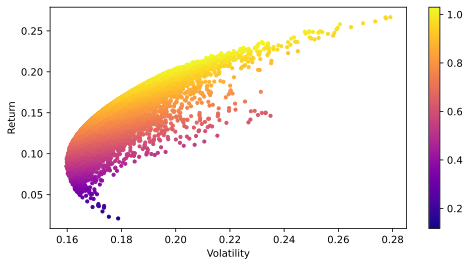

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(vol_arr, ret_arr, s=10, c=sharpe_arr, cmap='plasma')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar()

## 4. 组合优化


### 4.1 最大化夏普比率

构建一个计算收益率、波动和夏普比率的函数

In [12]:
def get_ret_vol_sr(weights):
    """
    把收益率、波动和夏普比率放进一个函数
    """
    weights = np.array(weights)
    ret = np.sum(log_ret.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
    sr = ret/vol
    return np.array([ret,vol,sr])

In [13]:
from scipy.optimize import minimize

scipy.optimize：提供了用于优化问题的函数，包括最小化和最大化目标函数、非线性方程求解、拟合曲线等功能。

进一步了解minimize如何使用，参见 [`scipy.optimize.minimize` 文档](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)。

优化工作是作为一个最小化函数进行的，因为我们实际上想要最大化夏普比率，所以我们需要将其转为负数，这样我们才能最小化负夏普（与最大化正夏普相同）。

In [14]:
def neg_sharpe(weights):
    return  get_ret_vol_sr(weights)[2] * -1

 检查权重的和

In [15]:
def check_sum(weights):
    '''
    如果权重总和为1，返回0
    '''
    return np.sum(weights) - 1

按照最小化函数的惯例，它应该是一个在特定条件下返回零的函数。

In [16]:
cons = ({'type':'eq','fun': check_sum})

每个权重的范围

In [17]:
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))

初始化权重，例如等权重

In [62]:
init_guess = [0.25,0.25,0.25,0.25]

开始最小化

In [19]:
opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)

优化完的结果如下

In [20]:
opt_results

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0307168703358962
       x: [ 2.663e-01  2.042e-01  4.375e-17  5.295e-01]
     nit: 7
     jac: [ 5.643e-05  4.184e-05  3.399e-01 -4.449e-05]
    nfev: 35
    njev: 7

最佳权重如下：

In [21]:
opt_results.x

array([2.66289766e-01, 2.04189821e-01, 4.37543339e-17, 5.29520412e-01])

对应的收益率(ret)、波动率(vol)和夏普比率(sr)值如下：

In [22]:
get_ret_vol_sr(opt_results.x)

array([0.21885916, 0.21233683, 1.03071687])

### 4.2 构建投资组合

使用得到的最佳权重，来构建投资组合

In [59]:
opt_port = opt_results.x * stock_normed

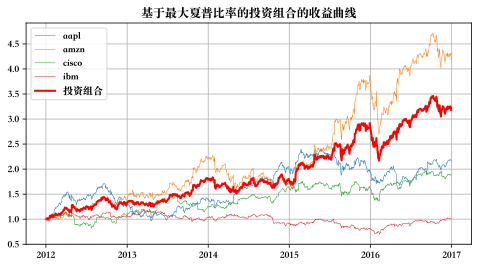

In [69]:
plt.rcParams['font.sans-serif'] = 'Songti SC'  # 设置字体为宋体
plt.figure(figsize=(8,4))   
plt.plot(stock_normed['aapl'], linewidth = 0.5, label='aapl')
plt.plot(stock_normed['amzn'], linewidth = 0.5, label='amzn')
plt.plot(stock_normed['cisco'], linewidth = 0.5, label='cisco')
plt.plot(stock_normed['ibm'], linewidth = 0.5, label='ibm')
plt.plot(opt_port.sum(axis=1), linewidth = 2,  color='red', label='投资组合')  
plt.legend()
plt.grid()
plt.title('基于最大夏普比率的投资组合的收益曲线')
plt.show()             

## 5. 有效前沿（Efficient Frontier）

首先，指定有效前沿在y轴上的坐标范围，如0-0.3，中间生成100个点

In [24]:
frontier_y = np.linspace(0,0.3,100)  

In [25]:
def minimize_volatility(weights):
    return  get_ret_vol_sr(weights)[1] 

在每次循环过程中，设置约束条件：
1. 总权重之和 - 1 = 0
2. 寻找最小波动时，计算出的组合收益率 - 给定的波动率 = 0

In [26]:
frontier_volatility = []

for possible_return in frontier_y:
    cons = ({'type':'eq','fun': check_sum},              
            {'type':'eq','fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})       
    
    result = minimize(minimize_volatility,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    
    frontier_volatility.append(result['fun'])

In [27]:
len(ret_arr)

10000

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.scatter(vol_arr, ret_arr, s=10, c=sharpe_arr, cmap='plasma')
plt.plot(frontier_volatility, frontier_y, '--')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar()

有效边界是一组最优投资组合，它为一定风险水平提供了最高的预期回报，或者对于给定预期回报水平提供了最低的风险。位于有效边界下方的投资组合是次优的，因为它们没有提供足够的回报来抵消风险水平。位于有效边界右侧的投资组合也是次优的，因为它们对于给定的预期回报率而言具有更高的风险水平。

## 参考

1. 组合优化：https://panel.holoviz.org/gallery/portfolio_optimizer.html
2. `scipy.optimize.minimize`方法，参见https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html